In [118]:
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.io import readsav
import glob
from pathlib import Path
import fitsio
from scipy.signal import convolve2d
from scipy.ndimage.filters import gaussian_filter 

def load_vel_mean(v_files, trange):
    "Load the velocity files and average over a time range"
    vxs = []
    vys = []
    vx_files_subset = v_files[0][trange[0]:trange[1]]
    vy_files_subset = v_files[1][trange[0]:trange[1]]
    for vxf, vyf in zip(vx_files_subset, vy_files_subset):
        vxs.append(fitsio.read(vxf))
        vys.append(fitsio.read(vyf))
    # Get the mean of the velocity components
    vx = np.array(vxs).mean(axis=0)
    vy = np.array(vys).mean(axis=0)
    return vx, vy


def smooth_vel(vxs, vys, fwhm, kernel='boxcar'):
    """ Smooth the velocity with a smoothing kernel that can either be: 
     - boxcar: width set to fwhm
     - gaussian: parametrized by fwhm. 
     
     Returns the smoothed velocity components
    """ 
    
    if kernel == 'boxcar':
        box = np.ones([fwhm, fwhm])/(fwhm**2)
        vxs2 = convolve2d(vxs, box, mode='same')
        vys2 = convolve2d(vys, box, mode='same')
    elif kernel == 'gaussian':
        sigma = fwhm / 2.35
        vxs2 = gaussian_filter(vxs, sigma=sigma, order=0)
        vys2 = gaussian_filter(vys, sigma=sigma, order=0)
        
    return vxs2, vys2


def calc_c_pearson(vx1, vx2, vy1, vy2, fov=None):
    vx1f, vx2f, vy1f, vy2f = vx1[fov], vx2[fov], vy1[fov], vy2[fov]
    c_pearson = np.sum(vx1f*vx2f + vy1f*vy2f) / np.sqrt(np.sum(vx1f**2 + vy1f**2)*np.sum(vx2f**2 + vy2f**2))
    return c_pearson


def v_fit(drifts, vmeans):
    ## Calibration parameters: y_measured = p0*x_true + p1 => true = (measured - p1)*1/p0
    p, r, _, _, _ = np.polyfit(drifts, vmeans, 1, full=True)
    pfit = np.poly1d(p)
    # Calculate residuals
    residuals = np.sqrt(r[0]/vmeans.size)
    return p, pfit, residuals


def read_vi(file, data_str):
    idl_dict = readsav(file)
    vi = idl_dict[data_str]
    return vi

matplotlib.rcParams.update({'font.size': 14})
matplotlib.rcParams.update({'xtick.labelsize': 12, 'ytick.labelsize': 12})

In [119]:
# Load stein velocity to get the true mean
data_dir_stein = os.path.expanduser('~/Data/Ben/SteinSDO/')
svx_files = sorted(glob.glob(os.path.join(data_dir_stein,'SDO_vx*.fits')))
svy_files = sorted(glob.glob(os.path.join(data_dir_stein,'SDO_vy*.fits')))

vx_stein, vy_stein = load_vel_mean((svx_files, svy_files), trange)
# Get true mean velocity (unit already in m/s)
vx_stein_mean = vx_stein.mean()
print(vx_stein_mean, 'm/s')
# smooth the Stein velocities 
vx_stein_sm, vy_stein_sm = smooth_vel(vx_stein, vy_stein, fwhm, kernel='boxcar')


-82.53004 m/s


In [120]:
# Unit (m/s)
u = 368000 / 60
# Index at zero drift
vidx = 5
dv = 0.04
drifts = np.arange(-0.2, 0.21, dv)
fwhm = 7
pad = 10
trange = [0,27]
# Set a subfield excluding edge effects
# Use same padding size as in Tremblay et al. 2018 used pad = 10
step = 10
fov = np.s_[pad:-pad:step, pad:-pad:step]

In [148]:
datadir = os.path.expanduser('~/Data/sanity_check/flct_results/')
lctfiles0 = list(Path(os.path.join(datadir, 'Stein-simulation-series')).rglob('flct-km-Stein-simul-*.save'))
lctfiles1 = list(Path(os.path.join(datadir, 'Stein-simulation-2skip')).rglob('flct-km-Stein-simul-*.save'))
lctfiles2 = list(Path(os.path.join(datadir, 'Stein-simulation-3skip')).rglob('flct-km-Stein-simul-*.save'))
lctfiles0.sort()
lctfiles1.sort()
lctfiles2.sort()
lctfiles = [lctfiles0, lctfiles1, lctfiles2]
# for filelist in lctfiles:
#     for f in filelist:
#         print(f)

In [149]:
vxs = [[read_vi(file, 'vx') for file in lctfiles_skip] for lctfiles_skip in lctfiles]
vys = [[read_vi(file, 'vy') for file in lctfiles_skip] for lctfiles_skip in lctfiles]
vxs2 = [np.array([vx[trange[0]:trange[1], pad:-pad, pad:-pad].mean()/(i+1) for vx in vxs_skip]) for i, vxs_skip in enumerate(vxs)]

In [150]:
# Fit the FLCT results
px, vfits, rmse = zip(*[v_fit(vxmeans, drifts + vx_stein_mean/u) for vxmeans in vxs2])
errors = [np.abs(vxmeans - (drifts + vx_stein_mean/u)) for i, vxmeans in enumerate(vxs2)]
maes = [err.mean() for err in errors]
residuals = [np.abs(vfits[i](vxmeans) - (drifts + vx_stein_mean/u)) for i, vxmeans in enumerate(vxs2)]
mads = [res.mean() for res in residuals]

In [151]:
px

(array([ 1.20074265, -0.00234283]),
 array([ 1.08741025, -0.0021629 ]),
 array([ 1.09129696, -0.00219368]))

## Plot FLCT velocity against drift velocity

<IPython.core.display.Javascript object>


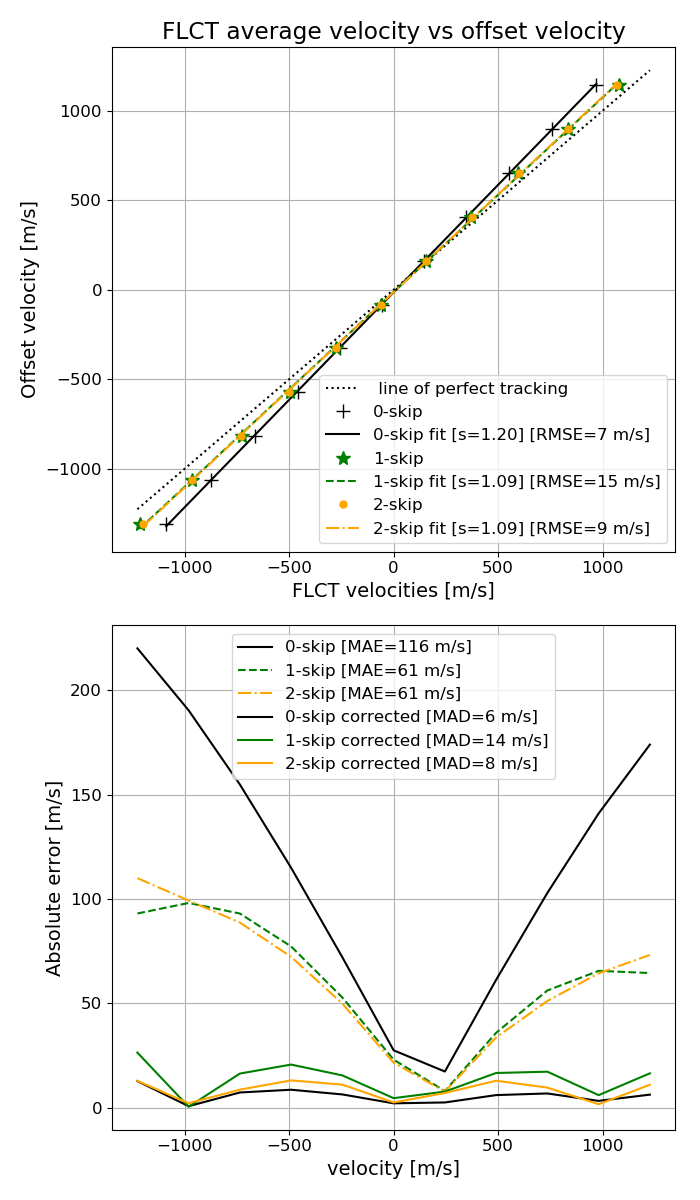

In [152]:

%matplotlib notebook
fs = 14
colors = ['black', 'green', 'orange']
markers = ['+', '*', '.']
ls = ['-', '--', '-.']
fig, ax = plt.subplots(2,1, figsize = (7,12))
ax[0].plot(drifts*u, drifts*u, 'k:', label=' line of perfect tracking')
for i in range(3):
    ax[0].plot(vxs2[i]*u, drifts*u + vx_stein_mean, marker=markers[i], ms=10, ls='none', color=colors[i], 
               label = '{:d}-skip'.format(i))
    ax[0].plot(vxs2[i]*u, vfits[i](vxs2[i])*u, ls=ls[i], color=colors[i], 
               label = '{:d}-skip fit [s={:1.2f}] [RMSE={:1.0f} m/s]'.format(i, px[i][0], rmse[i]*u))
ax[0].grid(True, axis='both')
ax[0].set_xlabel('FLCT velocities [m/s]')
ax[0].set_ylabel('Offset velocity [m/s]')
# plt.xlim([0, 2])
# plt.ylim([0, 2])
ax[0].legend(fontsize=12)
ax[0].set_title('FLCT average velocity vs offset velocity')


for i in range(3):
    ax[1].plot(drifts*u, errors[i]*u, ls=ls[i], color=colors[i], label = '{:d}-skip [MAE={:1.0f} m/s]'.format(i, maes[i]*u))

for i in range(3):
    ax[1].plot(drifts*u, residuals[i]*u, ls='-', color=colors[i], label = '{:d}-skip corrected [MAD={:1.0f} m/s]'.format(i, mads[i]*u))
    
ax[1].set_xlabel('velocity [m/s]')
ax[1].set_ylabel('Absolute error [m/s]')
ax[1].grid(True, axis='both')
ax[1].legend(fontsize=12)

plt.tight_layout()
plt.savefig(os.path.join(datadir, 'flct_sanity_check_on_drifts.png'), dpi=300)


#### Get FLCT at zero drift and calculate Pearson correlation with velocity from Stein simulation

In [153]:
vx_flct_list = [vxs_skip[vidx][trange[0]:trange[1],...].mean(axis=0)/(i+1) for i, vxs_skip in enumerate(vxs)]
vy_flct_list = [vys_skip[vidx][trange[0]:trange[1],...].mean(axis=0)/(i+1) for i, vys_skip in enumerate(vys)]

x = np.linspace(-2000, 2000, 100)
px = []
rx = []
npts = vx_stein_sm[fov].size
for i in range(3):
    p, r, _, _, _ = np.polyfit(vx_flct_list[i][fov].ravel()*u, vx_stein_sm[fov].ravel(), 1, full=True)
    px.append(p)
    rx.append(np.sqrt(r[0]/npts))

In [154]:
c_pearsons = [calc_c_pearson(vx_stein_sm, vx_flct, vy_stein_sm, vy_flct, fov=fov) for (vx_flct, vy_flct) 
              in zip(vx_flct_list, vy_flct_list)]

print(c_pearsons)

[0.8524640506277671, 0.8366842674226173, 0.7498749944965959]


<IPython.core.display.Javascript object>


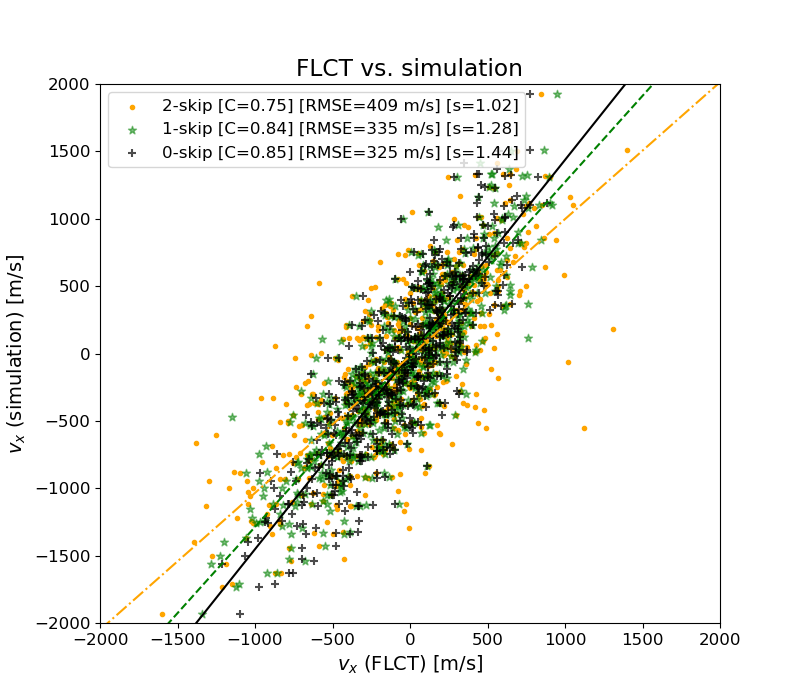

In [156]:
%matplotlib notebook

plt.figure(figsize=(8,7))

plt.scatter(vx_flct_list[2][fov].ravel()*u, vx_stein_sm[fov].ravel(), marker='.', color=colors[2], alpha=1.0, label = '2-skip [C={:1.2f}] [RMSE={:1.0f} m/s] [s={:1.2f}]'.format(c_pearsons[2], rx[2], px[2][0]))
plt.scatter(vx_flct_list[1][fov].ravel()*u, vx_stein_sm[fov].ravel(), marker='*', color=colors[1], alpha=0.5, label = '1-skip [C={:1.2f}] [RMSE={:1.0f} m/s] [s={:1.2f}]'.format(c_pearsons[1], rx[1], px[1][0]))
plt.scatter(vx_flct_list[0][fov].ravel()*u, vx_stein_sm[fov].ravel(), marker='+', color=colors[0], alpha=0.7, label = '0-skip [C={:1.2f}] [RMSE={:1.0f} m/s] [s={:1.2f}]'.format(c_pearsons[0], rx[0], px[0][0]))

for i in range(3):
    plt.plot(x, np.poly1d(px[i])(x), ls[i], color=colors[i])

plt.axis([-2000, 2000, -2000, 2000])
plt.xlabel(r'$v_x$ (FLCT) [m/s]')
plt.ylabel(r'$v_x$ (simulation) [m/s]')
plt.legend(fontsize=12)
plt.title('FLCT vs. simulation')
plt.savefig(os.path.join(datadir, 'flct_simulation_correlations.png'), dpi=300)